In [1]:

# DATA PREPROCESSING

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

# Ensure you have the necessary NLTK data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Data
data_df = pd.read_csv('airline_reviews.csv')

# Data Cleaning
# a. Filter Trip-Verified Reviews
data_df = data_df[data_df['Review Body'].str.startswith("✅Trip Verified")]

# b. Remove Duplicates
data_df = data_df.drop_duplicates(subset=['Review Body'], keep='first')

# c. Handle Missing Values
# Remove rows with missing critical fields (for example, Ratings)
data_df = data_df.dropna(subset=['Type of Traveller', 'Food & Beverages', 'Entertainment', 'Seat Comfort', 'Cabin Staff Service', 'Value For Money'])

# Text Normalization
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stop words
    return text

data_df['Cleaned Review Body'] = data_df['Review Body'].apply(clean_text)

# Encode Categorical Data
# Use Label Encoding for binary categories and One-Hot Encoding for others
label_encoder = LabelEncoder()

# Binary Encoding for 'Recommended' ('yes'/'no' -> 1/0)
data_df['Recommended'] = label_encoder.fit_transform(data_df['Recommended'])

# Label Encoding for 'Type of Traveller' and 'Seat Type' (few unique values)
data_df['Type of Traveller'] = label_encoder.fit_transform(data_df['Type of Traveller'])
data_df['Seat Type'] = label_encoder.fit_transform(data_df['Seat Type'])

# One-Hot Encoding for 'Airline' (multiple unique values)
data_df = pd.get_dummies(data_df, columns=['Airline'], drop_first=True)

# Output the transformed DataFrame
print("Data after preprocessing and encoding:")
print(data_df.head())

# Save the preprocessed and encoded data to a new CSV file
data_df.to_csv('preprocessed_reviews.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thejasri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data after preprocessing and encoding:
                 Date                                        Review Body  \
0  27th November 2024  ✅Trip Verified| I recently flew Qatar Airways ...   
1  26th November 2024  ✅Trip Verified| "Love at First Flight". I took...   
2  26th November 2024  ✅Trip Verified|   The flight lived up to expec...   
3  25th November 2024  ✅Trip Verified| Chaotic check-in at Kathmandu....   
4  24th November 2024  ✅Trip Verified|   The best thing about this ai...   

   Type of Traveller  Seat Type                         Route     Date Flown  \
0                  3          0                 Osaka to Doha  November 2024   
1                  0          1  London to Singapore via Doha  November 2024   
2                  3          1       Doha to London Heathrow  November 2024   
3                  3          1             Kathmandu to Doha  November 2024   
4                  3          1                London to Doha   October 2024   

   Food & Beverages  En

In [2]:
# FEATURE ENGINEERING

import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure you have the necessary NLTK data
nltk.download('vader_lexicon')

# Load the preprocessed data
data_df = pd.read_csv('preprocessed_reviews.csv')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to apply VADER and label sentiment based on the compound score
def get_sentiment_score(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # Extract the compound score as a general sentiment score

def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment functions to the cleaned review text
data_df['Sentiment Score'] = data_df['Cleaned Review Body'].apply(get_sentiment_score)
data_df['Sentiment Label'] = data_df['Sentiment Score'].apply(get_sentiment_label)

# Aspect-based Sentiment Analysis
aspect_keywords = {
    'Food & Beverages': ['food', 'meal', 'drink', 'beverage', 'snack'],
    'Entertainment': ['entertainment', 'movies', 'tv', 'music', 'game', 'wifi'],
    'Seat Comfort': ['seat', 'comfort', 'legroom', 'space'],
    'Cabin Staff Service': ['staff', 'service', 'crew', 'attendant'],
    'Value For Money': ['value', 'price', 'money', 'cost', 'worth']
}

# Function to calculate sentiment for a given aspect phrase
def aspect_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Function to perform aspect-based sentiment analysis
def get_aspect_sentiments(review):
    aspect_sentiments = {}
    for aspect, keywords in aspect_keywords.items():
        # Extract sentences related to the current aspect
        aspect_text = ' '.join([sentence for sentence in review.split('.') 
                                if any(keyword in sentence for keyword in keywords)])
        
        # Calculate sentiment score for the aspect text if not empty
        aspect_sentiments[aspect + ' Sentiment Score'] = aspect_sentiment(aspect_text) if aspect_text else 0
        aspect_sentiments[aspect + ' Sentiment Label'] = get_sentiment_label(aspect_sentiments[aspect + ' Sentiment Score'])
    return aspect_sentiments

# Apply aspect-based sentiment analysis to each review
aspect_sentiments_df = data_df['Cleaned Review Body'].apply(get_aspect_sentiments).apply(pd.Series)

# Merge the aspect sentiments back into the main DataFrame
data_df = pd.concat([data_df, aspect_sentiments_df], axis=1)

# List of aspect rating columns already present in data
aspect_rating_columns = ['Food & Beverages', 'Entertainment', 'Seat Comfort', 
                         'Cabin Staff Service', 'Value For Money']

# Calculate Aggregate Rating for each review based on the available aspect ratings
data_df['Aggregate Rating'] = data_df[aspect_rating_columns].mean(axis=1)

# Add the Seat Type column
data_df['Seat Type'] = data_df['Seat Type']  # Ensure 'Seat Type' is in your data

# Remove discrepancies (Positive sentiment with low ratings or Negative sentiment with high ratings)
cleaned_data_df = data_df[~((data_df['Sentiment Label'] == 'Positive') & (data_df['Aggregate Rating'] < 3.0)) &
                          ~((data_df['Sentiment Label'] == 'Negative') & (data_df['Aggregate Rating'] >= 3.0))]

# Output the DataFrame with the new sentiment columns, aspect ratings, aspect sentiment scores, aggregate rating, and seat type
print("Data after Feature Engineering:")
print(data_df[['Cleaned Review Body', 'Sentiment Score', 'Sentiment Label', 'Aggregate Rating', 'Seat Type'] + 
              aspect_rating_columns + 
              [col for col in aspect_sentiments_df.columns]].head())

# Save the DataFrame with sentiment data, aspect ratings, aspect sentiment scores, aggregate rating, and seat type to a new CSV file
data_df.to_csv('feature_engineered.csv', index=False) 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thejasri/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Data after Feature Engineering:
                                 Cleaned Review Body  Sentiment Score  \
0  trip verified recently flew qatar airways busi...           0.4091   
1  trip verified love first flight took qatar air...           0.9371   
2  trip verified flight lived expectations though...           0.9022   
3  trip verified chaotic checkin kathmandu airpor...          -0.1769   
4  trip verified best thing airline good training...           0.9524   

  Sentiment Label  Aggregate Rating  Seat Type  Food & Beverages  \
0        Positive               2.2          0               1.0   
1        Positive               5.0          1               5.0   
2        Positive               4.6          1               5.0   
3        Negative               4.8          1               5.0   
4        Positive               4.8          1               5.0   

   Entertainment  Seat Comfort  Cabin Staff Service  Value For Money  \
0            4.0           3.0                  

Basic Information Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   4818 non-null   object 
 1   Review Body                            4818 non-null   object 
 2   Type of Traveller                      4818 non-null   int64  
 3   Seat Type                              4818 non-null   int64  
 4   Route                                  4817 non-null   object 
 5   Date Flown                             4818 non-null   object 
 6   Food & Beverages                       4818 non-null   float64
 7   Entertainment                          4818 non-null   float64
 8   Seat Comfort                           4818 non-null   float64
 9   Cabin Staff Service                    4818 non-null   float64
 10  Value For Money                        4818 

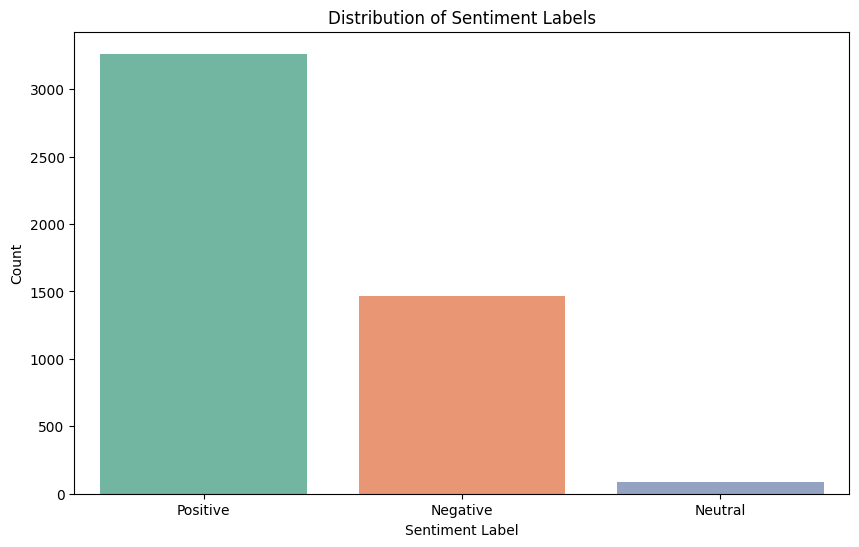

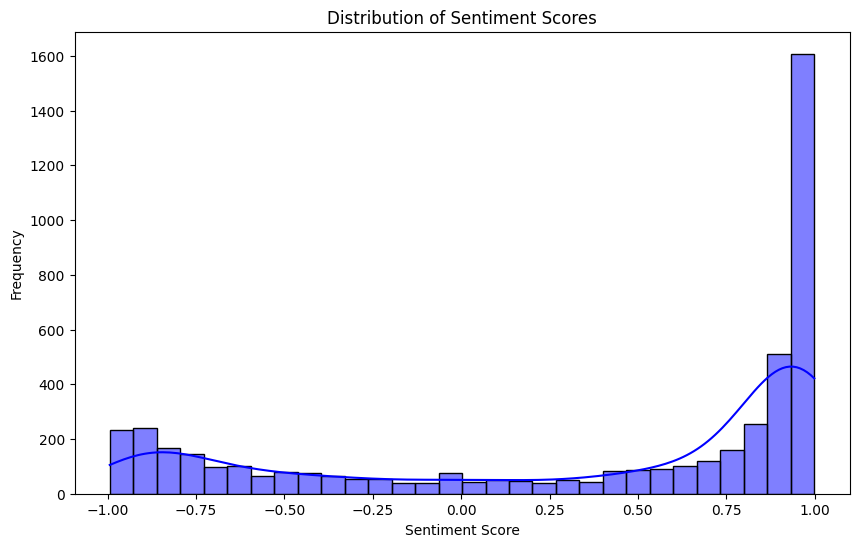


Aggregate Rating Summary
count    4818.000000
mean        3.381154
std         1.273877
min         1.000000
25%         2.400000
50%         3.600000
75%         4.600000
max         5.000000
Name: Aggregate Rating, dtype: float64


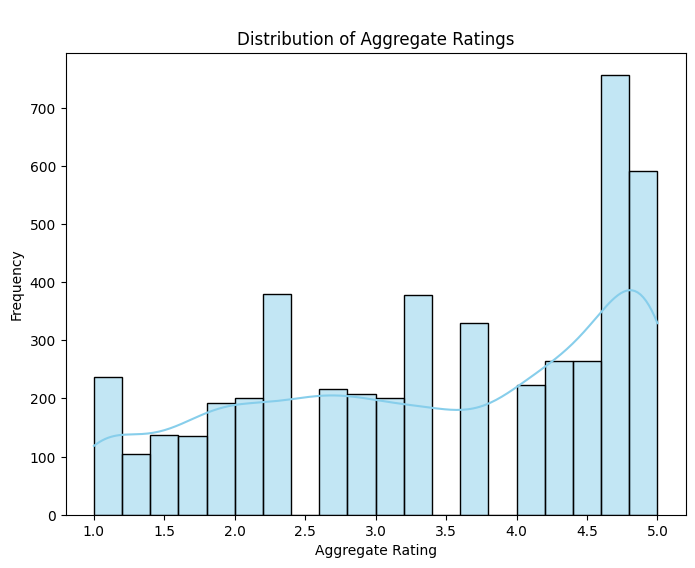

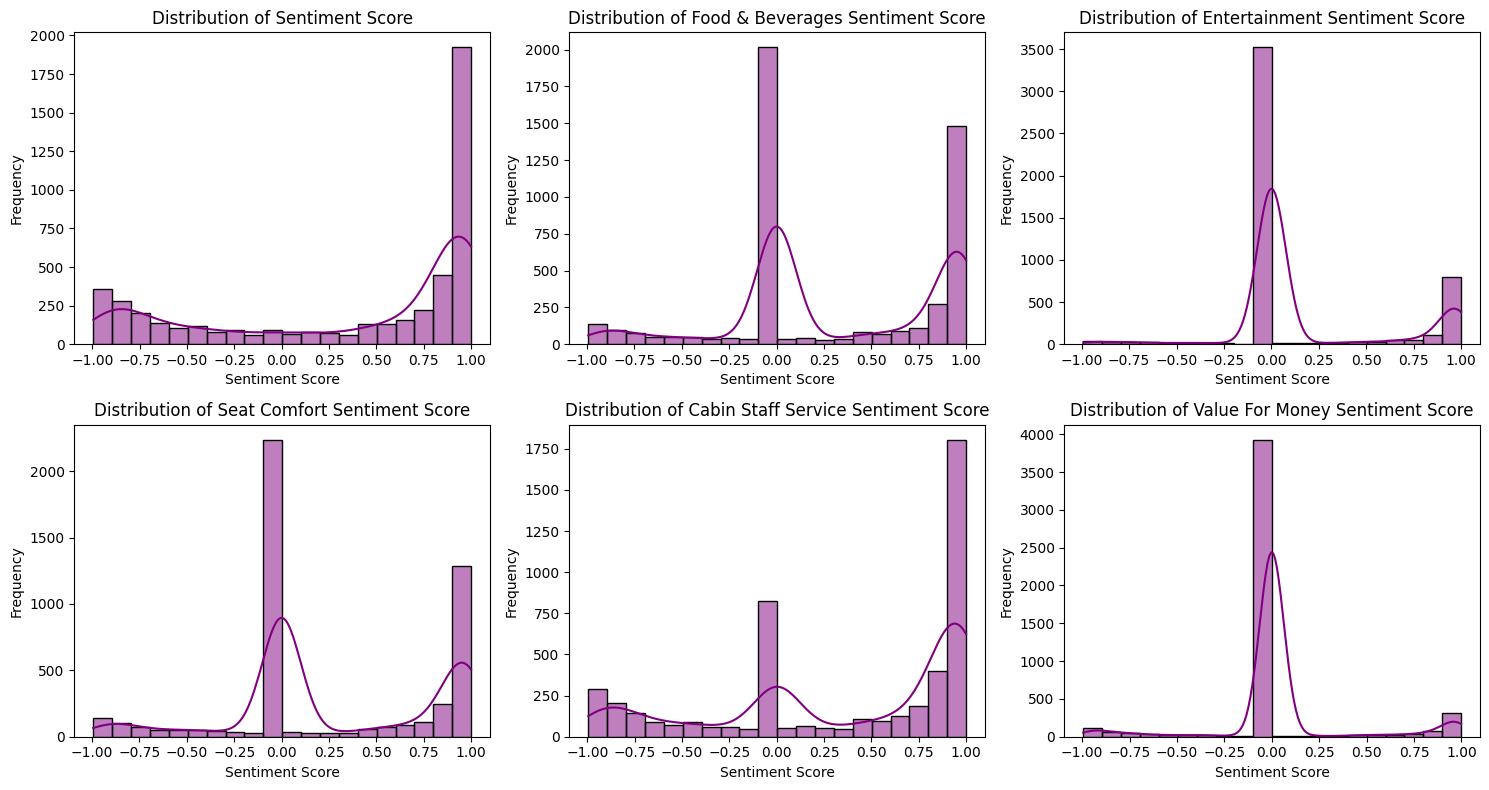

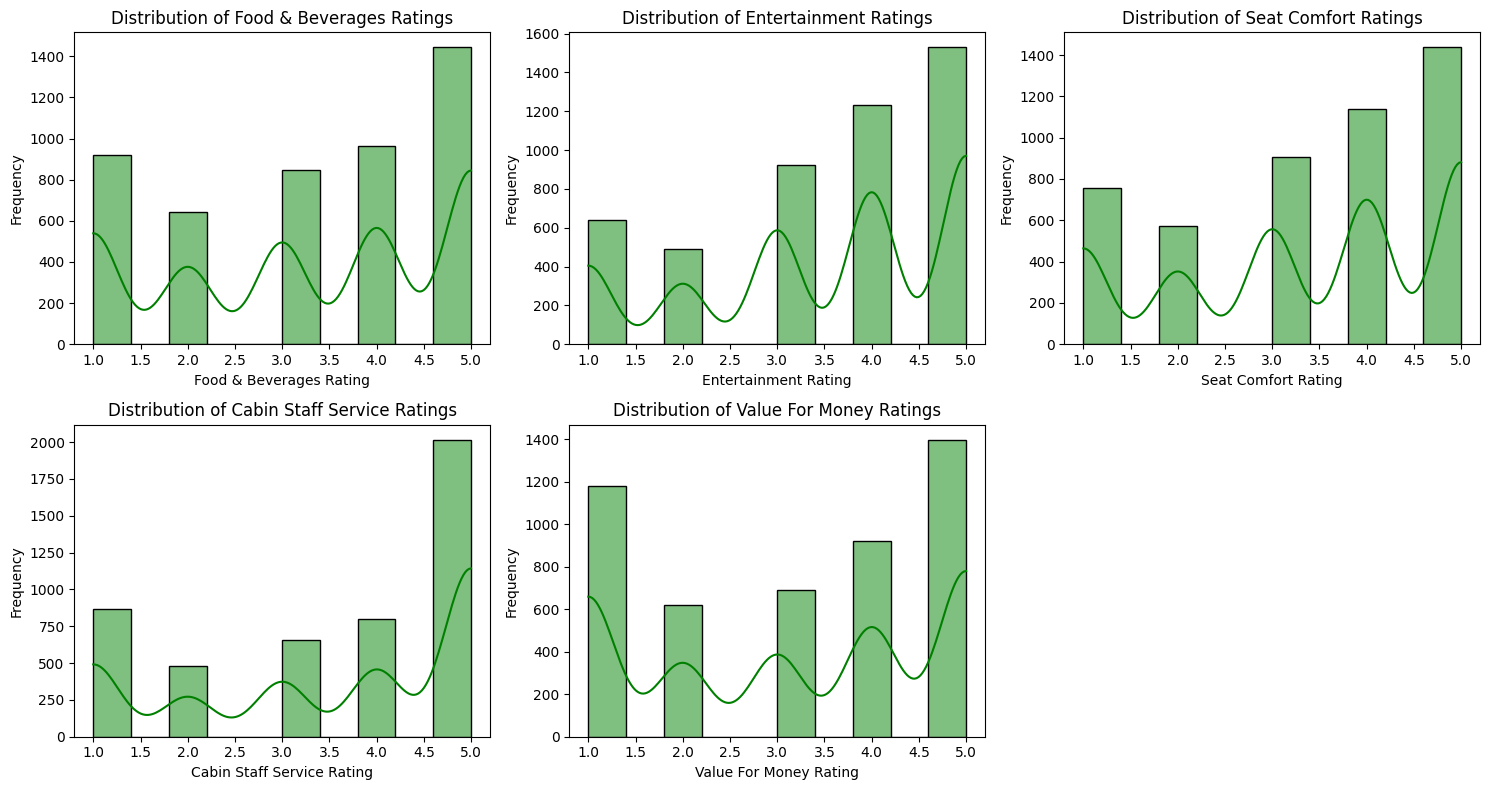

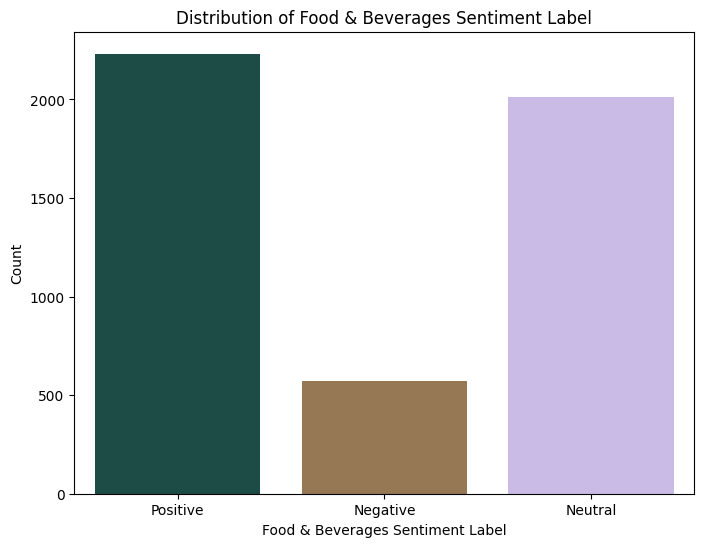

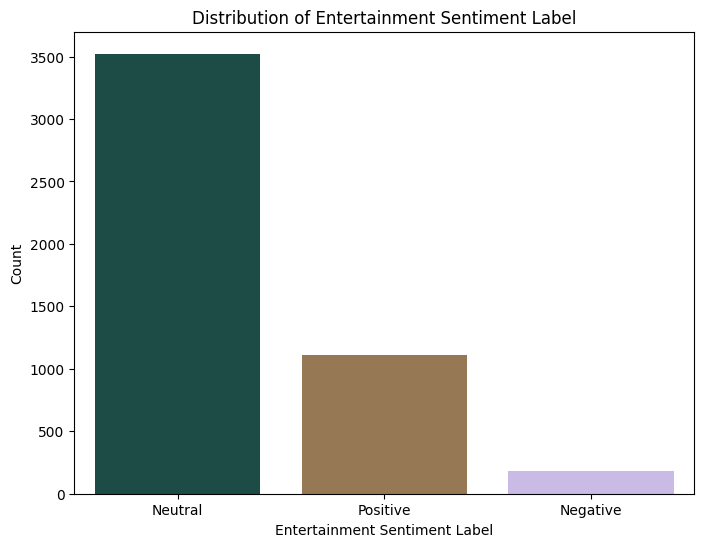

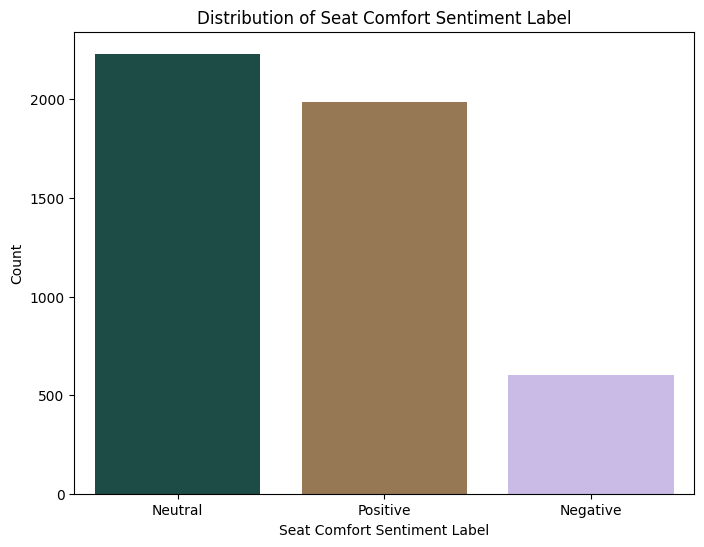

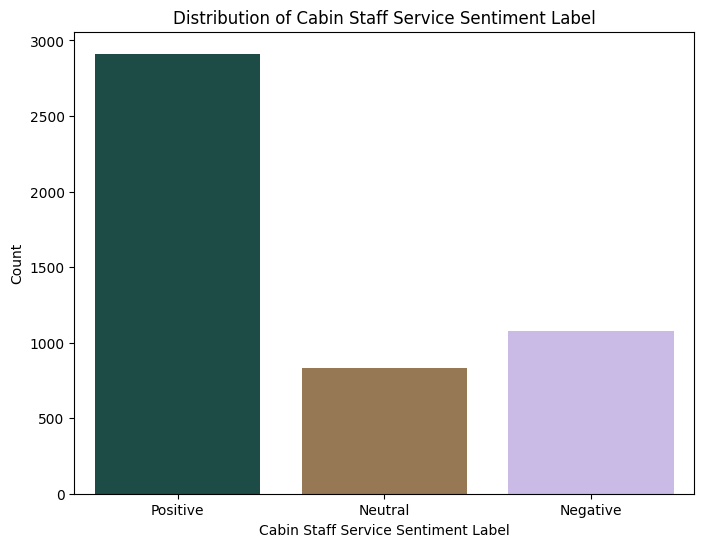

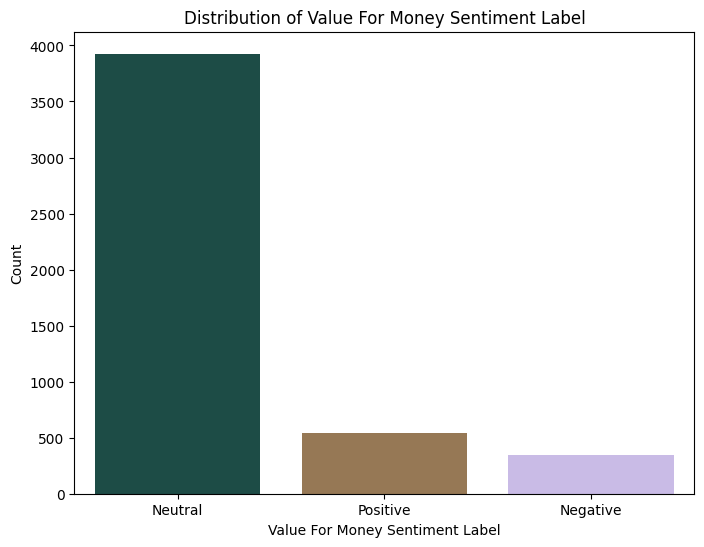

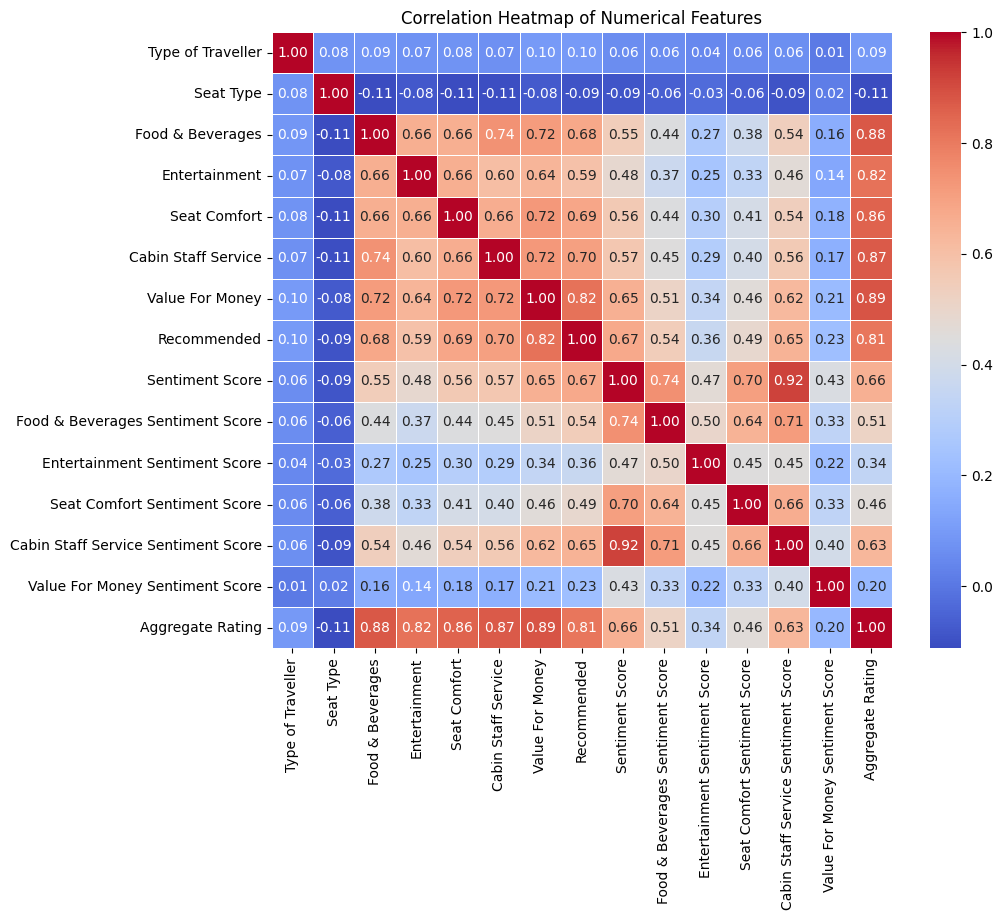

EDA complete.


In [3]:
# EDA and VISUALIZATION

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data with sentiment and aspect-based sentiment information
data_df = pd.read_csv('feature_engineered.csv')


# Basic Information Overview
print("Basic Information Overview:")
print(data_df.info())

# Check for missing values
print("\nMissing Values:")
print(data_df.isnull().sum())

# Descriptive Statistics
print("\nDescriptive Statistics:")
print(data_df.describe())

# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data_df, x='Sentiment Label', hue='Sentiment Label', palette='Set2', legend=False)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

# Sentiment Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_df['Sentiment Score'], kde=True, bins=30, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Aggregate Rating distribution 
print("\nAggregate Rating Summary")
print(data_df['Aggregate Rating'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(data=data_df, x='Aggregate Rating', bins=20, kde=True, color='skyblue')
plt.title("\nDistribution of Aggregate Ratings")
plt.xlabel("Aggregate Rating")
plt.ylabel("Frequency")
plt.show()


# Aspect Sentiment Analysis
# Sentiment distribution for each aspect
aspect_columns = [col for col in data_df.columns if 'Sentiment Score' in col]
plt.figure(figsize=(15, 8))
for i, aspect in enumerate(aspect_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(data_df[aspect], kde=True, bins=20, color='purple')
    plt.title(f'Distribution of {aspect}')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Aspect Rating Distribution
# Aspect Rating distribution for each aspect (e.g., Food & Beverages, Entertainment, etc.)
aspect_rating_columns = ['Food & Beverages', 'Entertainment', 'Seat Comfort', 'Cabin Staff Service', 'Value For Money']

plt.figure(figsize=(15, 8))
for i, aspect in enumerate(aspect_rating_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(data_df[aspect], kde=True, bins=10, color='green')
    plt.title(f'Distribution of {aspect} Ratings')
    plt.xlabel(f'{aspect} Rating')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Distribution of Sentiment Labels by Aspect with 'cubehelix' palette
aspect_sentiment_labels = [col for col in data_df.columns if 'Sentiment Label' in col and col != 'Sentiment Label']
for aspect_label in aspect_sentiment_labels:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data_df, x=aspect_label, hue=aspect_label, palette='cubehelix', legend=False)
    plt.title(f"Distribution of {aspect_label}")
    plt.xlabel(aspect_label)
    plt.ylabel("Count")
    plt.show()

# Selecting only numerical columns
numerical_columns = data_df.select_dtypes(include='number').columns

# Compute the correlation matrix for numerical features
corr_matrix = data_df[numerical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

print("EDA complete.")


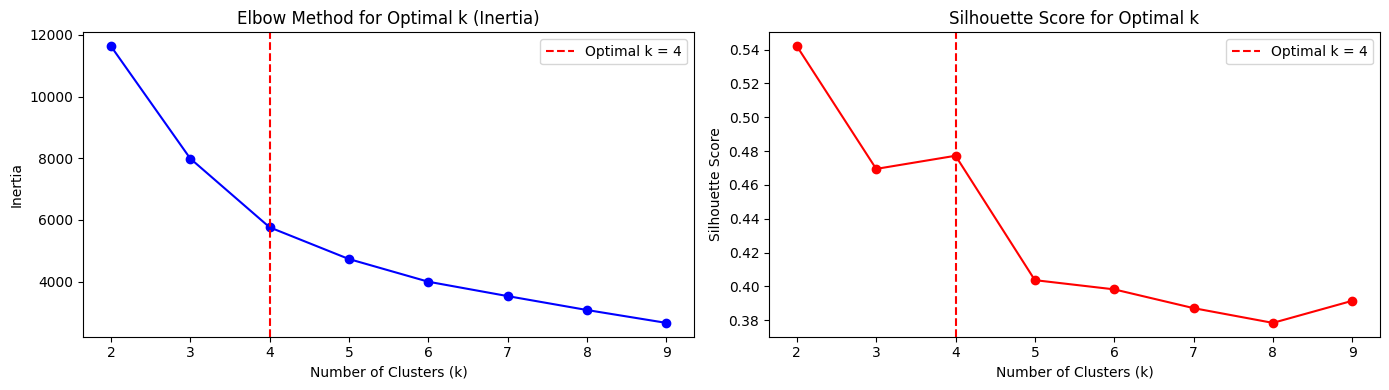

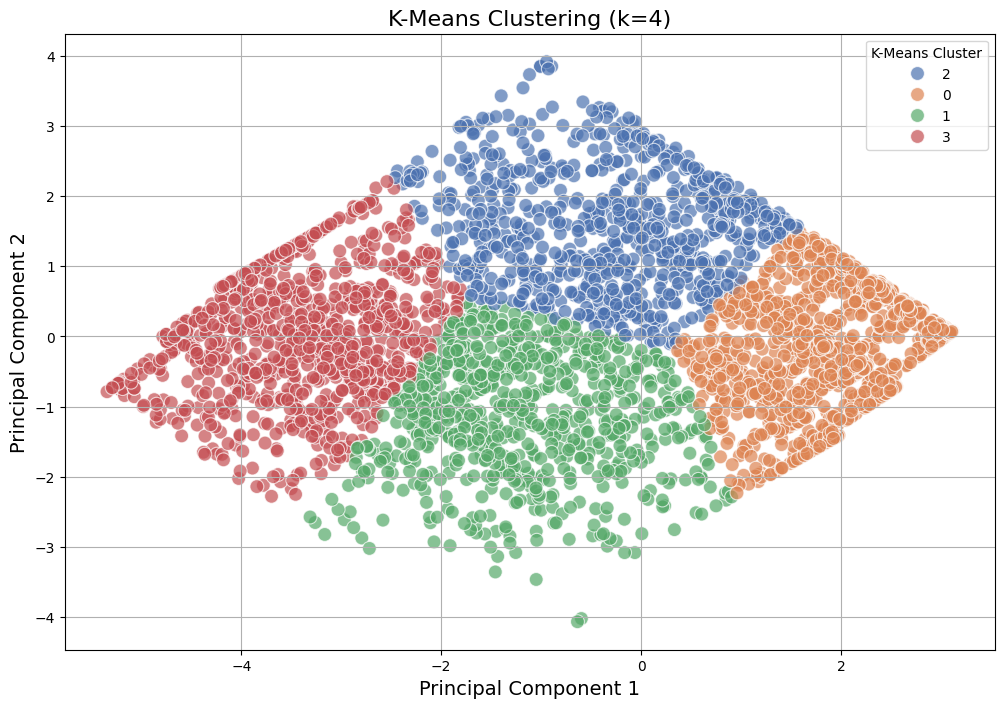

K-Means Clustering Results:
Number of Clusters: 4
Inertia: 5761.21988595997


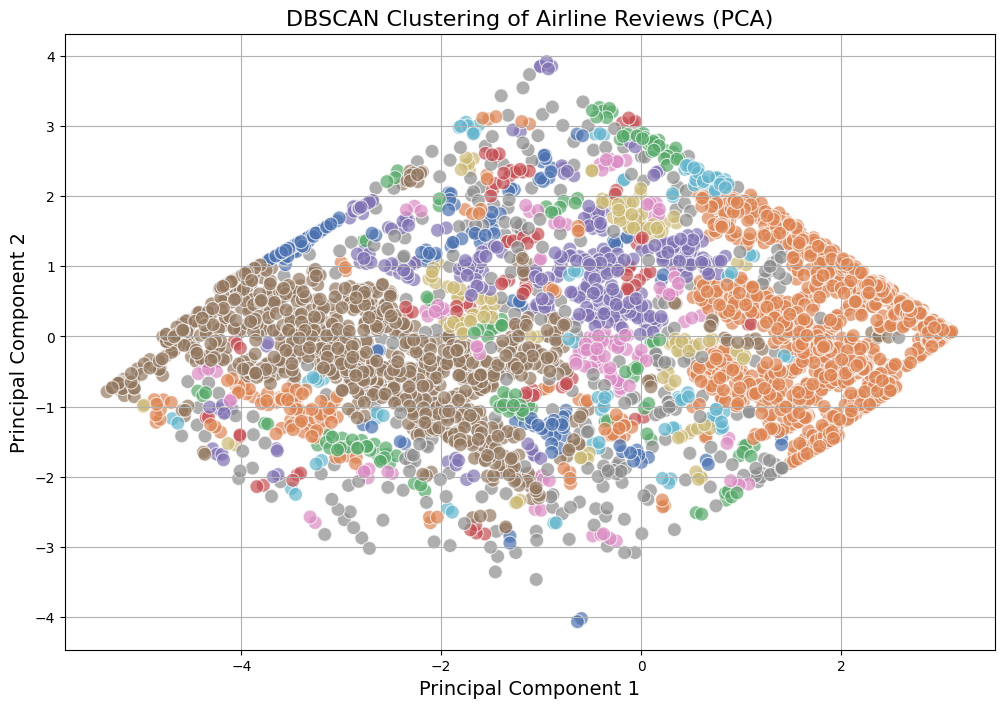


DBSCAN Clustering Results:
Number of Clusters: 231


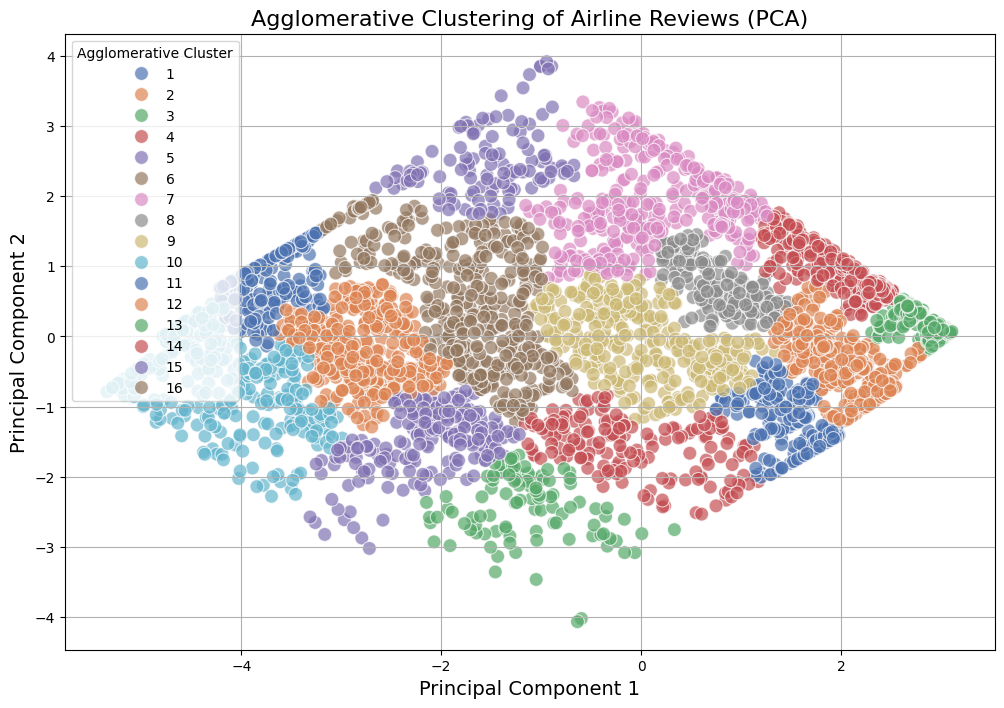


Agglomerative Clustering Results:
Number of Clusters: 16


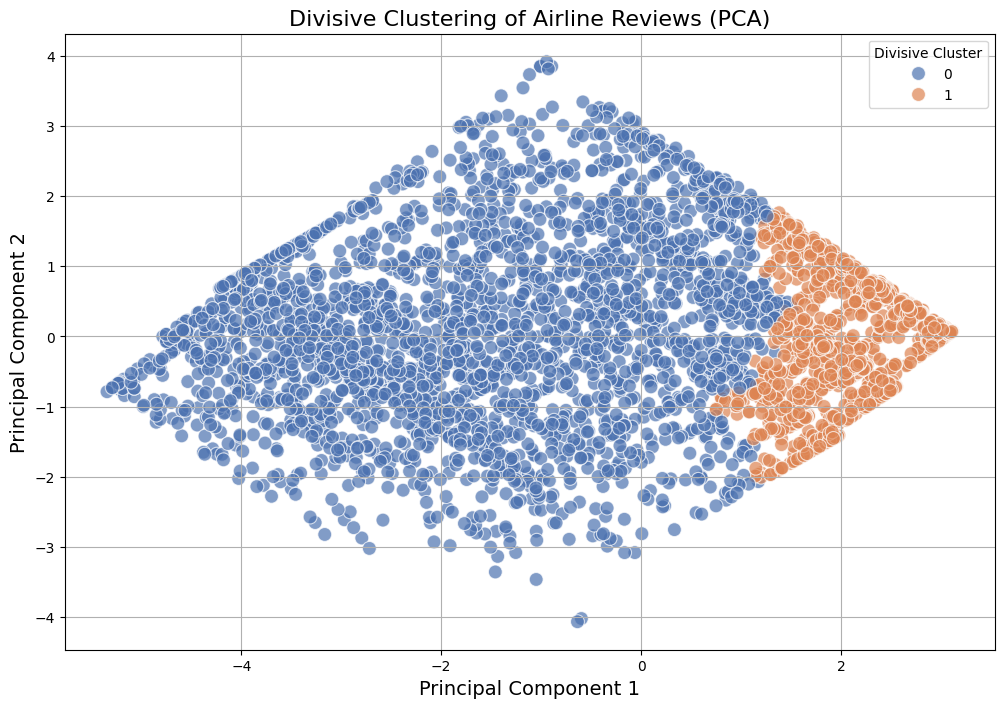


Divisive Clustering Results:
Number of Clusters: 2

SILHOUTTE SCORES:


In [ ]:
# CLUSTERING

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster

# Load the feature-engineered dataset
data_df = pd.read_csv('feature_engineered.csv')

# Select the relevant numerical columns for clustering
features = ['Sentiment Score', 'Aggregate Rating', 'Seat Comfort Sentiment Score',
'Food & Beverages Sentiment Score',                                         
'Cabin Staff Service Sentiment Score', 'Food & Beverages',                             
'Seat Comfort',                 
'Cabin Staff Service'                                                               
  ]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(data_df[features])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_imputed)

# Apply PCA for dimensionality reduction (let's reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe
data_df['PC1'] = pca_features[:, 0]
data_df['PC2'] = pca_features[:, 1]

# Helper function to visualize clustering results
def visualize_clusters(data, labels, title, centroids=None):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data['PC1'], y=data['PC2'], hue=labels, palette='viridis', s=100, alpha=0.7, edgecolor='k')
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title(title, fontsize=16)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Elbow method for optimal k with inertia and silhouette score
inertia = []
silhouette_scores = []
k_range = range(2, 10)  # Start from k=2, as silhouette score is not defined for k=1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    
    # Append inertia for elbow method
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score and append
    silhouette_avg = silhouette_score(pca_features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

optimal_k = 4  # Set based on Elbow Method or Silhouette Score analysis

# Plot Elbow Method results (Inertia)
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Inertia)')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

# Plot Silhouette Score results
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

# Perform K-Means Clustering using PCA features
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_df['KMeans Cluster'] = kmeans.fit_predict(pca_features)

# K-Means Clustering Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], 
                y=pca_features[:, 1], 
                hue=data_df['KMeans Cluster'].astype(str), 
                palette='deep', 
                s=100, 
                alpha=0.7, 
                edgecolor='w')
plt.title(f'K-Means Clustering (k={optimal_k})', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='K-Means Cluster')
plt.grid(True)
plt.show()
# K-Means Evaluation Metrics
print("K-Means Clustering Results:")
print(f"Number of Clusters: {data_df['KMeans Cluster'].nunique()}")
print(f"Inertia: {kmeans.inertia_}")

# Step 1: DBSCAN Clustering using PCA features
dbscan = DBSCAN(eps=0.1, min_samples=2)  # Adjust eps and min_samples as necessary
data_df['DBSCAN Cluster'] = dbscan.fit_predict(pca_features)

# DBSCAN Clustering Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], 
                y=pca_features[:, 1], 
                hue=data_df['DBSCAN Cluster'].astype(str), 
                palette='deep', 
                s=100, 
                alpha=0.7, 
                edgecolor='w',
                legend=False)  # Disable the legend

plt.title('DBSCAN Clustering of Airline Reviews (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True)
plt.show()

# Print DBSCAN Summary
print("\nDBSCAN Clustering Results:")
print("Number of Clusters:", data_df['DBSCAN Cluster'].nunique() - 1)  # Subtract 1 for noise points (-1)

# Step 2: Agglomerative Clustering (Hierarchical) using PCA features
linkage_matrix = linkage(pca_features, method='ward')

# Cut the dendrogram to create clusters
threshold = 15  # Adjust this threshold based on your dendrogram if needed
data_df['Agglomerative Cluster'] = fcluster(linkage_matrix, threshold, criterion='distance')

# Agglomerative Clustering Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], 
                y=pca_features[:, 1], 
                hue=data_df['Agglomerative Cluster'], 
                palette='deep', 
                s=100, 
                alpha=0.7, 
                edgecolor='w')

plt.title('Agglomerative Clustering of Airline Reviews (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Agglomerative Cluster')
plt.grid(True)
plt.show()

# Print Agglomerative Summary
print("\nAgglomerative Clustering Results:")
print("Number of Clusters:", data_df['Agglomerative Cluster'].nunique())

# Divisive Hierarchical Clustering (AgglomerativeClustering) using PCA features
agglom = AgglomerativeClustering(n_clusters=2, linkage='ward')

# Assign divisive cluster labels using .loc to avoid SettingWithCopyWarning
data_df.loc[:, 'Divisive Cluster'] = agglom.fit_predict(pca_features)

# Divisive Clustering Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], 
                y=pca_features[:, 1], 
                hue=data_df['Divisive Cluster'], 
                palette='deep', 
                s=100, 
                alpha=0.7, 
                edgecolor='w')

plt.title('Divisive Clustering of Airline Reviews (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Divisive Cluster')
plt.grid(True)
plt.show()

# Print Divisive Summary
print("\nDivisive Clustering Results:")
print("Number of Clusters:", data_df['Divisive Cluster'].nunique())

print("\nSILHOUTTE SCORES:")

# K-Means Silhouette Score
kmeans_silhouette = silhouette_score(pca_features, data_df['KMeans Cluster'])
print(f"\nK-Means Silhouette Score: {round(kmeans_silhouette, 3)}")

# DBSCAN Silhouette Score (exclude noise points (-1) from both pca_features and labels)
dbscan_labels = data_df['DBSCAN Cluster']
dbscan_mask = dbscan_labels != -1  # Mask to exclude noise points
dbscan_silhouette = silhouette_score(pca_features[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"\nDBSCAN Silhouette Score: {round(dbscan_silhouette, 3)}")

# Agglomerative Clustering Silhouette Score
agglo_silhouette = silhouette_score(pca_features, data_df['Agglomerative Cluster'])
print(f"\nAgglomerative Clustering Silhouette Score: {round(agglo_silhouette, 3)}")

# Divisive Clustering Silhouette Score
divisive_silhouette = silhouette_score(pca_features, data_df['Divisive Cluster'])
print(f"\nDivisive Clustering Silhouette Score: {round(divisive_silhouette, 3)}")

# Compare and print the best clustering algorithm
silhouette_scores = {
    'K-Means': kmeans_silhouette,
    'DBSCAN': dbscan_silhouette,
    'Agglomerative': agglo_silhouette,
    'Divisive': divisive_silhouette
}

# Find the best algorithm with the highest silhouette score
best_algorithm = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nBest Algorithm based on Silhouette Score: {best_algorithm}")

In [ ]:
# VISUALIZING K-MEANS CLUSTERS WITH CENTROIDS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get PCA component loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)

# Display the loadings to see feature contributions
print("Feature contributions to PCA components:")
print(loadings)

# Plot loadings for a visual representation
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contribution to PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

# Assigning descriptive cluster names based on feature analysis
cluster_names = {
    0: 'Elite Flyers',        
    1: 'Content Flyers',      
    2: 'Happy Flyers',        
    3: 'Frustrated Flyers'    
}

# Map the cluster labels to names
data_df['Cluster Name'] = data_df['KMeans Cluster'].map(cluster_names)

# Visualize the clusters in the PCA space with assigned names
plt.figure(figsize=(12, 8))

# Scatter plot of points, color-coded by cluster
sns.scatterplot(x=pca_features[:, 0], 
                y=pca_features[:, 1], 
                hue=data_df['KMeans Cluster'].astype(str), 
                palette='deep', 
                s=100, 
                alpha=0.7, 
                edgecolor='w')

# Mark the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

# Set custom legend labels for clusters
handles, labels = plt.gca().get_legend_handles_labels()

# Replace numeric labels with the descriptive cluster names
label_map = {str(k): v for k, v in cluster_names.items()}
new_labels = [label_map[label] if label in label_map else label for label in labels]

# Add the legend with the descriptive cluster names
plt.legend(handles=handles, labels=new_labels + ['Centroids'], title='Cluster Name')

plt.title('Cluster Visualization with PCA Components and Centroids', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True)
plt.show()

# Print summary statistics and interpretation for each cluster
for name in cluster_names.values():
    print(f"\n{name} Summary:")
    cluster_data = data_df[data_df['Cluster Name'] == name][features].mean()
    print(cluster_data)

    # Interpretation based on the feature averages
    if name == 'Elite Flyers':
        print("""
Interpretation: This cluster represents the most satisfied passengers, with very high sentiment scores and aggregate ratings. 
\n'Elite Flyers' have an exceptional experience across all service aspects, indicating top-tier satisfaction in food, seat comfort, and cabin staff service. These passengers are highly engaged and loyal.
\nInsight: Airlines should focus on nurturing this group with loyalty programs, premium services, and personalized experiences. Ensuring that these passengers feel valued will help maintain their high satisfaction levels.
        """)
    elif name == 'Content Flyers':
        print("""
Interpretation: This cluster shows moderate satisfaction, with slightly negative sentiment scores but favorable ratings in key areas like food, comfort, and service. 
\n'Content Flyers' represent passengers who are generally satisfied but may have areas where improvements could be made. 
\nInsight: Airlines should focus on enhancing small aspects of the experience (e.g., improving seat comfort or food quality) to increase satisfaction and potentially convert them into "Elite Flyers."
        """)
    elif name == 'Happy Flyers':
        print("""
Interpretation: While this cluster has slightly lower ratings and moderate dissatisfaction, the positive sentiment scores in some areas suggest that these passengers still maintain a generally good impression of the airline. 
\n'Happy Flyers' are not fully satisfied but their overall sentiment remains positive. 
\nInsight: Airlines have the opportunity to turn these passengers' experience around. Improving their experiences in specific service areas (like food or cabin service) could elevate them to higher satisfaction levels.
        """)
    elif name == 'Frustrated Flyers':
        print("""
Interpretation: This cluster exhibits the lowest ratings and negative sentiment across all service aspects. These passengers are highly dissatisfied with their experience, particularly with seat comfort, food, and staff service.
\n'Frustrated Flyers' are the most at risk of churn and dissatisfaction. 
\nInsight: Airlines must take immediate action to address the concerns of this group. This could include significant service improvements or offering compensations to restore their satisfaction. Targeted recovery programs are necessary to win back their trust.
        """)
